# Notebook 2, Classification
### Marsha Genevieve Nandana - 2702217522

In [144]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [145]:
#gen dcgan

LATENT_DIM = 100
IMG_SIZE = 64 #ukuran gambar yang bakal dihasilin
def build_generator():
    model = keras.Sequential(name="Generator")

    #1. vecotr noise 1D jadi fondasi 3D (4x4)
    model.add(layers.Dense(4 * 4 * 1024, input_shape=(LATENT_DIM,)))
    model.add(layers.Reshape((4, 4, 1024)))
    
    #Conv2DTranspose utk memperbesar gambar
    #2. upsampling 4x4 -> 8x8
    model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) # Aktivasi ReLU di generator

    #3. upsampling 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    #4. upsampling 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    #5. output 32x32 -> 64x64
    #filterny 3 (RGB)
    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same'))
    
   
    #'tanh' -> output pixel antara -1 dan 1.
    model.add(layers.Activation('tanh'))

    return model


generator = build_generator()
generator.summary()

/opt/homebrew/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 16384)          │     1,654,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 8, 8, 512)      │     8,389,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 64, 64, 3)      │         6,147 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,675,459 (48.35 MB)

 Trainable params: 12,673,667 (48.35 MB)

 Non-trainable params: 1,792 (7.00 KB)

# 2c. Generate 500 images by using the trained model from point a.

In [146]:
#generate 500 image pke model yang udah ditrain
generator = build_generator() 
generator.load_weights('whale_generator_model_1000epochs.h5') #model 1000 epochs (beda)

print("good")
#hyperparameter
LATENT_DIM = 100 #samain psm pas training
NUM_IMAGES_TO_GENERATE = 500

#buat noise acak sebagai input
noise = tf.random.normal([NUM_IMAGES_TO_GENERATE, LATENT_DIM])

#genearte
fake_images = generator.predict(noise)

#denormalisasi gambar (dari [-1, 1] ke [0, 255]), biar datanya seragam dengan gambar asli
fake_images = (fake_images * 127.5) + 127.5
fake_images = fake_images.astype('uint8') # Ubah jadi integer 0-255

print(f"made {fake_images.shape[0]} fake (generated) whale image.")
print(f"shpae: {fake_images.shape} ")  #hrsnya (500, 64, 64, 3)

good
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step
made 500 fake (generated) whale image.
shpae: (500, 64, 64, 3) 


In [147]:
#generated dataset
GENERATED_FOLDER = "generated_fake_images"


#os.makedirs(GENERATED_FOLDER, exist_ok=True)
#print(f"saving {fake_images.shape[0]} images to {GENERATED_FOLDER}")

#loop & save tiap gmambar
for i in range(fake_images.shape[0]):
    img = fake_images[i]
    
    file_name = f"fake_whale_{i+1:03d}.png"
    file_path = os.path.join(GENERATED_FOLDER, file_name)

    #####jadi harus konversi RGB -> BGR sebelum saving krn cv2.imwrite() menyimpan gambar sebagai BGR, sedangkan model menghasilkan gambar RGB
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(file_path, img_bgr)

print(f"done, {fake_images.shape[0]} images saved")

saving 500 images to generated_fake_images
done, 500 images saved


# 2e. Construct a new dataset for classification with 2 classes: original and fake. Use your original training dataset as the original class and the generated images from point b as the fake class.

In [148]:

#original dataset(train)
ORIGINAL_DATA_DIR = "./train/whale" 
IMAGE_SIZE = 64

original_images = []
image_files = os.listdir(ORIGINAL_DATA_DIR)


for i, file_name in enumerate(image_files):
    if i >= NUM_IMAGES_TO_GENERATE: #batesin 500 gambar
        break
    
    img_path = os.path.join(ORIGINAL_DATA_DIR, file_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #BGR to RGB
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    original_images.append(img)
original_images = np.array(original_images)

print(f"done loaded {original_images.shape[0]} original images")
print(f"asli shape: {original_images.shape}") #hrsnya (500, 64, 64, 3)


#gabungin set
X_data = np.concatenate([fake_images, original_images], axis=0)


# 0 = fake, 1 = original
y_fake = np.zeros(NUM_IMAGES_TO_GENERATE)
y_original = np.ones(NUM_IMAGES_TO_GENERATE)
y_data = np.concatenate([y_fake, y_original], axis=0)

#normalisasi data (0-255 -> 0-1) (classification)
X_data = X_data.astype('float32') / 255.0


print(f"images total (X_data shape): {X_data.shape}") #hrs (1000, 64, 64, 3)
print(f"labels (y_data shape): {y_data.shape}")   #(1000)

done loaded 500 original images
asli shape: (500, 64, 64, 3)
images total (X_data shape): (1000, 64, 64, 3)
labels (y_data shape): (1000,)


In [149]:

#splitiing
X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_data, 
    test_size=0.2, 
    random_state=42,
    shuffle=True #
)

print(f"Data Training (X): {X_train.shape}") #800, 64, 64, 3
print(f"Data Validasi (X): {X_val.shape}")  #200, 64, 64, 3
print(f"Data Training (y): {y_train.shape}") #800,
print(f"Data Validasi (y): {y_val.shape}")  #200

Data Training (X): (800, 64, 64, 3)
Data Validasi (X): (200, 64, 64, 3)
Data Training (y): (800,)
Data Validasi (y): (200,)


# 2f. Construct and train a deep learning model to classify original versus fake images by using the dataset from point d.

In [150]:

IMAGE_SIZE = 64

def build_classifier():
    model = keras.Sequential(name="Classifier_Original_vs_Fake")
    
    #input layer
    model.add(layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    
    #Conv 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    #Conv 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    #Conv 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    
    #dense layer
    model.add(layers.Dense(128, activation='relu'))
    #dropout untuk atasi overfitting (buat 2h)
    model.add(layers.Dropout(0.5)) 
    
    #output layer (binary classficication)
    model.add(layers.Dense(1, activation='sigmoid')) #1 neuron, sigmoid
    
    return model

classifier_model = build_classifier()
classifier_model.summary()

Model: "Classifier_Original_vs_Fake"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,081 (4.36 MB)

 Trainable params: 1,142,081 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [151]:
#compile model
classifier_model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #loss untuk klasifikasi biner
    metrics=['accuracy']
)

#hyperparameter
EPOCHS = 20 #masi bisa nambah
BATCH_SIZE = 32
history = classifier_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val) 
)

print("tes")

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5213 - loss: 0.7022 - val_accuracy: 0.6350 - val_loss: 0.6837
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6137 - loss: 0.6641 - val_accuracy: 0.6600 - val_loss: 0.6147
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7075 - loss: 0.5581 - val_accuracy: 0.7800 - val_loss: 0.4672
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8012 - loss: 0.4549 - val_accuracy: 0.8200 - val_loss: 0.4230
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8250 - loss: 0.3793 - val_accuracy: 0.8100 - val_loss: 0.4077
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8662 - loss: 0.3185 - val_accuracy: 0.8600 - val_loss: 0.3194
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9050 - loss: 0.2492 - val_accuracy: 0.8850 - val_loss: 0.2569
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9312 - loss: 0.1739 - val_accuracy: 0.9000 - v

# 2g. Plot the training and validation losses over epochs, analyze, and explain what happened in the classification training based on the plot.

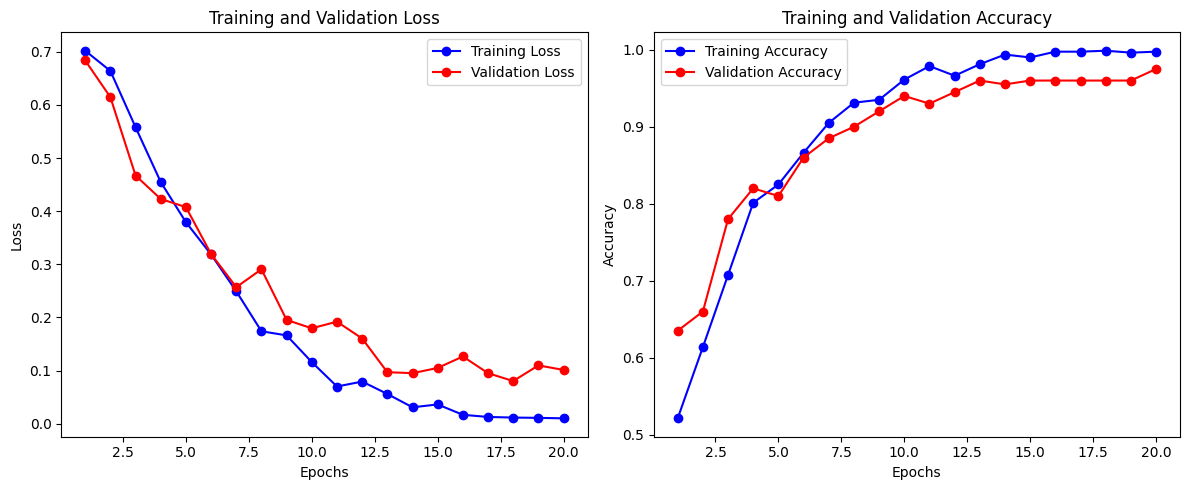

In [152]:

#dari history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

- Training Loss (biru) turun konsisten mendekati 0.
- Validation Loss (merah) juga ikut turun, namun setelah Epoch 10-12, garis validasi mulai stagnan dan sedikit naik (memantul), sementara loss training terus turun.

Ini adalah tanda overfitting kecil, di mana model mulai terlalu hafal data training.

# 2i. Test the classification model on a separate test set with appropriate metrics.

In [154]:

TEST_ORIGINAL_DIR = "./test/whale" 
IMAGE_SIZE = 64
LATENT_DIM = 100

test_original_images = []
test_image_files = os.listdir(TEST_ORIGINAL_DIR)

print(f"{len(test_image_files)} images from test dataset")

for file_name in test_image_files:
    img_path = os.path.join(TEST_ORIGINAL_DIR, file_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"fail, {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    test_original_images.append(img)

test_original_images = np.array(test_original_images)
num_test_images = len(test_original_images)


print(f"made {num_test_images} fake images for the test set")

#generatornya
noise = tf.random.normal([num_test_images, LATENT_DIM])
test_fake_images = generator.predict(noise) #[-1, 1]

test_fake_images = (test_fake_images * 127.5) + 127.5
test_fake_images = test_fake_images.astype('uint8') # Jadi [0, 255]
X_test = np.concatenate([test_fake_images, test_original_images], axis=0)

#y_test (0=fake, 1=original)
y_fake_test = np.zeros(num_test_images)
y_original_test = np.ones(num_test_images)
y_test = np.concatenate([y_fake_test, y_original_test], axis=0)

X_test = X_test.astype('float32') / 255.0

print("done")
print(f"Bentuk X_test: {X_test.shape}")
print(f"Bentuk y_test: {y_test.shape}")

100 images from test dataset
made 100 fake images for the test set
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
done
Bentuk X_test: (200, 64, 64, 3)
Bentuk y_test: (200,)


Test Loss: 0.0779
Test Accuracy: 96.50%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
classfication report
                precision    recall  f1-score   support

Class 0 (fake)       0.99      0.94      0.96       100
 Class 1 (ori)       0.94      0.99      0.97       100

      accuracy                           0.96       200
     macro avg       0.97      0.96      0.96       200
  weighted avg       0.97      0.96      0.96       200

[[94  6]
 [ 1 99]]


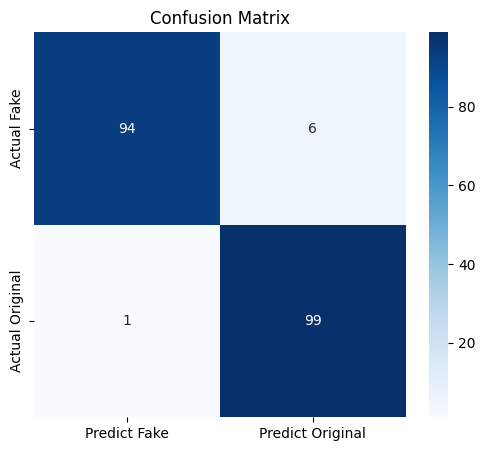

In [155]:
from sklearn.metrics import classification_report, confusion_matrix

loss, accuracy = classifier_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


y_pred_probs = classifier_model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

#classification report
print("classfication report")
target_names = ['Class 0 (fake)', 'Class 1 (ori)']
print(classification_report(y_test, y_pred_classes, target_names=target_names))

#confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predict Fake', 'Predict Original'],
            yticklabels=['Actual Fake', 'Actual Original'])
plt.title('Confusion Matrix')
plt.show()

# 2h: Do hyperparameter tuning to improve the deep learning model based on the result of point b and any other results you get from the training process.

Berdasarkan plot training/validation loss, terlihat ada tanda" overfitting ringan di epoch 10-12.
Saya akan melakukan tuning dengan menambahkan EarlyStopping untuk mencegah overfitting.

Monitor 'val_loss', dan jika tidak ada perbaikan (penurunan) selama 3 epoch (patience=3), training akan otomatis berhenti dan return best weights

In [156]:
#samain aja
#split
X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_data,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

#instance model baru
tuned_classifier_model = build_classifier()

#compile model
tuned_classifier_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

#hyperparameter training
EPOCHS = 50 ###
BATCH_SIZE = 32

#train pake callback
history_tuned = tuned_classifier_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback] #
)

print("done")

#evaluations
loss_tuned, accuracy_tuned = tuned_classifier_model.evaluate(X_test, y_test, verbose=0)
print(f"tuned test toss: {loss_tuned:.4f}")
print(f"tuned test accuracy: {accuracy_tuned * 100:.2f}%")

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5288 - loss: 0.6984 - val_accuracy: 0.5950 - val_loss: 0.6729
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6725 - loss: 0.6209 - val_accuracy: 0.7550 - val_loss: 0.5218
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7387 - loss: 0.5245 - val_accuracy: 0.7650 - val_loss: 0.5105
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8163 - loss: 0.4091 - val_accuracy: 0.8400 - val_loss: 0.3636
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8838 - loss: 0.2835 - val_accuracy: 0.8950 - val_loss: 0.2752
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9225 - loss: 0.1936 - val_accuracy: 0.9300 - val_loss: 0.1709
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9425 - loss: 0.1601 - val_accuracy: 0.9300 - val_loss: 0.2013
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9650 - loss: 0.0984 - val_accuracy: 0.9550 - v

hasilnya sedikit lebih bagus dari sebelumnya